## This is a demo of Adaptive Quadrature

Again, we prefer nested quadrature rules.

The first code block has some basic and composite quadrature rules.  The
basic rules are called as interval rules for adaptive quadrature.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def trap(integrand,a,b):
    return .5*(b-a)*(integrand(a)+integrand(b))

def simpson(integrand,a,b):
    c=.5*(a+b)
    return 1/6*(b-a)*(integrand(a)+4*integrand(c)+integrand(b))

def comp_trap(integrand,a,b,n):
    pts=np.linspace(a,b,n+1)
    fpts=integrand(pts)
    return .5*(b-a)/n*(fpts[0]+2*np.sum(fpts[1:-1])+fpts[-1])

def comp_simp(integrand,a,b,n):
    pts=np.linspace(a,b,2*n+1)
    fpts=integrand(pts)
    return 1/6*(b-a)/n*(fpts[0]+2*np.sum(fpts[2:-1:2])+4*np.sum(fpts[1:-1:2])+fpts[-1])
 
def gauss(integrand,a,b,deg=2):
    u_p,weights=np.polynomial.legendre.leggauss(deg)
    pts=(b-a)/2*u_p + (b+a)/2
    return (b-a)/2*np.sum(weights*integrand(pts))

## Inputs:
* integrand: callable function being integrated.
* a: lower limit of integration default=0 
* b: upper limit of integration.  Both must be finite. default=1
* rule: callable function giving interval rule.  default=trap(trapezoidal)
* order: required, for building error control.  Should equal order of **rule**
* tol: global error tolerance (defaults to 1E-12) 
* intervals: don't touch, for future feature
* maxint: maximum number of intervals (defaults to 1000), do not set higher without changing *recursion depth* in python.
* debug: (defaults to False) prints verbose output
* plot: (defaults to False) plot integrand and interval endpoints.


In [3]:
def adapt_quad(integrand,a=0,b=1,rule=trap,order=2,tol=1E-12,intervals=2,maxint=1000,debug=False,plot=False):
    ans=0
    mid=.5*(b+a)
    full=rule(integrand,a,b)  
    half=rule(integrand,a,mid)+rule(integrand,mid,b)  
    #half can be any other estimator with "better accuracy"
    if np.absolute(full-half) < (b-a)*(2**order-1)*tol:
        if plot:
            plt.plot([a,mid,b],[integrand(a),integrand(mid),integrand(b)])
            plt.scatter([a,b],[0,0])
        ans=half
        if debug:
            print('Final interval',a,b)
        return ans,intervals
    elif intervals >= maxint:
        ans=half
        if plot:
            plt.plot([a,mid,b],[integrand(a),integrand(mid),integrand(b)])
            plt.scatter([a,b],[0,0])
        if debug:
            print('Maximum # of Intervals Reached')
        return ans,intervals
    else:
        if debug:
            print('split interval',intervals,a,b,np.absolute(full-half))
        intervals+=1
        #bisect and call recursively
        temp,intervals=adapt_quad(integrand,a,mid,rule,order,tol,intervals,maxint,debug,plot)
        ans+=temp
        temp,intervals=adapt_quad(integrand,mid,b,rule,order,tol,intervals,maxint,debug,plot)
        ans+=temp
    return ans,intervals

In [4]:
# SOME FUNCTIONS FOR TESTING.

def normal(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

def easy(x):
    return np.exp(x)

def tough(x):
    return 1+np.sin(np.exp(5*x))

def atan(x):
    return np.arctan(x)

split interval 2 0 10 0.362504410696
split interval 3 0 5.0 0.100787306857
split interval 4 0 2.5 0.000656440832422
split interval 5 0 1.25 0.00164627072383
split interval 6 0 0.625 9.07553230189e-05
split interval 7 0 0.3125 2.10212490369e-06
Final interval 0 0.15625
Final interval 0.15625 0.3125
split interval 8 0.3125 0.625 2.54782311016e-06
Final interval 0.3125 0.46875
Final interval 0.46875 0.625
split interval 9 0.625 1.25 5.71053290954e-06
Final interval 0.625 0.9375
Final interval 0.9375 1.25
split interval 10 1.25 2.5 0.000182155518521
split interval 11 1.25 1.875 7.91868644168e-06
Final interval 1.25 1.5625
Final interval 1.5625 1.875
split interval 12 1.875 2.5 3.69410479706e-06
Final interval 1.875 2.1875
Final interval 2.1875 2.5
split interval 13 2.5 5.0 0.000524818028345
split interval 14 2.5 3.75 3.3219186951e-05
Final interval 2.5 3.125
Final interval 3.125 3.75
split interval 15 3.75 5.0 7.7912219425e-06
Final interval 3.75 4.375
Final interval 4.375 5.0
split interv

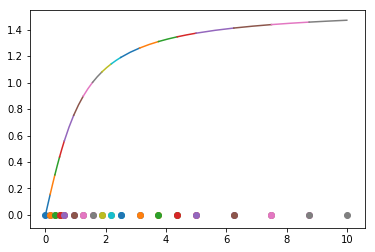

In [6]:
plt.figure()
#fig1=plt.figure(figsize=(10,10))
int3,intervals=adapt_quad(atan,a=0,b=10,tol=1E-6,rule=gauss,debug=True,plot=True)
true=10*np.arctan(10)-.5*np.log(101)
print('Error',int3-true)
print(intervals)
plt.show()

In [33]:
#test on arctan
true=10*np.arctan(10)-.5*np.log(101)
n=2**np.arange(1,8)
int1=np.zeros(n.size)
int2=np.copy(int1)
int3=np.copy(int1)
int4=np.copy(int1)
nad=np.copy(int1)
nad2=np.copy(int1)
ix=0
for l in n:
    #print(l)
    int1[ix]=comp_trap(atan,0,10,l)
    int2[ix]=comp_simp(atan,0,10,l)
    int4[ix],nad2[ix]=adapt_quad(atan,a=0,b=10,tol=(10/l)**3,rule=trap,order=2,debug=False)
    int3[ix],nad[ix]=adapt_quad(atan,a=0,b=10,tol=(10/l)**5,rule=simpson,order=4,debug=False)
    ix+=1
err_trap=np.absolute(int1-true)
err_simp=np.absolute(int2-true)
err_adap=np.absolute(int3-true)
err_ad_trap=np.absolute(int4-true)


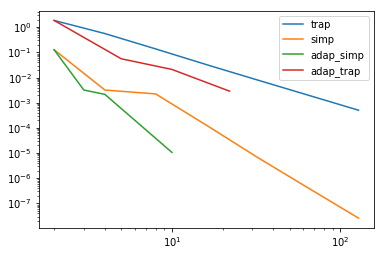

In [34]:
plt.figure()
plt.loglog(n,err_trap,label='trap')
plt.loglog(n,err_simp,label='simp')
plt.loglog(nad,np.absolute(true-int3),label='adap_simp')
plt.loglog(nad2,np.absolute(true-int4),label='adap_trap')
plt.legend()

plt.show()

## Tough Function 



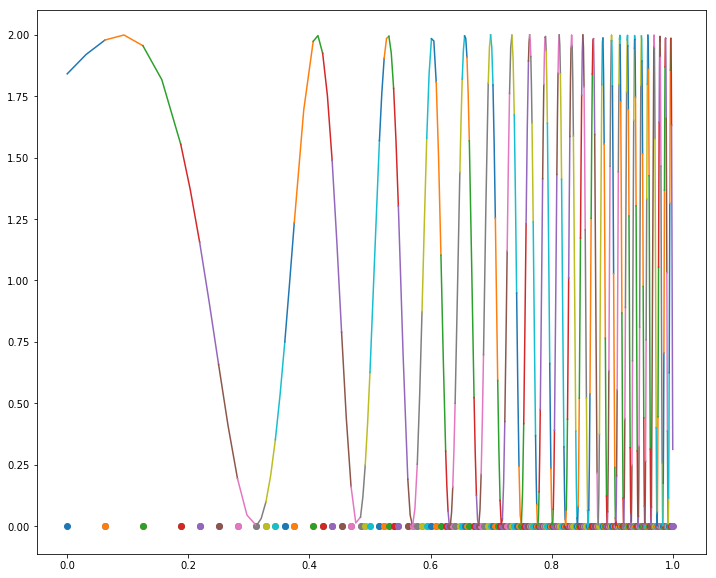

(1.1259275776776136, 216)


In [40]:
plt.figure(figsize=(12,10))
tst=adapt_quad(tough,rule=simpson,order=4,tol=1E-5,plot=True,debug=False)
plt.show()
print(tst)